In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    print("GPU found and memory growth enabled.")
else:
    print("No GPU found. Using CPU.")

GPU found and memory growth enabled.


In [5]:
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
#read all file
all_files_path=glob('drive/MyDrive/edf_files/*.edf')
print(len(all_files_path))

28


In [7]:
all_files_path[0]

'drive/MyDrive/edf_files/s12.edf'

In [8]:
healthy_file_path=[i for i in all_files_path if  'h' in i.split('/')[3]]
patient_file_path=[i for i in all_files_path if  's' in i.split('/')[3]]

In [9]:
# ----------- READ & PREPROCESS SINGLE SUBJECT ----------- #
def read_data(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

    # Keep EEG only
    raw.pick_types(eeg=True)

    # Average reference
    raw.set_eeg_reference('average', projection=False)

    # Remove line noise
    raw.notch_filter(freqs=[50, 100], verbose=False)

    # Bandpass filter (0.5–50 Hz for final analysis)
    raw.filter(l_freq=0.5, h_freq=50, verbose=False)

    # ---------- ICA (Thesis style) ----------
    filt_raw = raw.copy()
    # Only high-pass at 0.5 Hz, no low-pass because Nyquist = 125
    filt_raw.load_data().filter(l_freq=0.5, h_freq=None, verbose=False)

    ica = mne.preprocessing.ICA(n_components=15, max_iter='auto', random_state=97, method="fastica")
    ica.fit(filt_raw)

    # Identify and exclude EOG/artifact components
    eog_inds, _ = ica.find_bads_eog(raw, ch_name=['Fp1','Fp2'])
    ica.exclude = eog_inds

    # Apply ICA
    raw = ica.apply(raw)

    # ---------- Epoch into non-overlapping 5s ----------
    epochs = mne.make_fixed_length_epochs(raw, duration=5, overlap=1, preload=True)
    return epochs.get_data()   # shape = (trials, channels, samples)

In [10]:
data=read_data(healthy_file_path[0])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.5s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass for

In [11]:
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.6s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass for

In [12]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))

14 14


In [13]:
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))

28 28


In [14]:
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [15]:
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
data_array=np.moveaxis(data_array,1,2)

print(data_array.shape,label_array.shape,group_array.shape)

(7201, 1250, 19) (7201,) (7201,)


In [16]:
# Hybrid CNN + Transformer Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.backend import clear_session

def build_eeg_transformer(input_shape=(1250, 19), num_classes=1):
    clear_session()

    inputs = layers.Input(shape=input_shape)  # (time, channels)

    # Step 1: Local feature extraction with Conv1D
    x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Step 2: Learnable Positional Encoding (using Embedding)
    time_steps = input_shape[0]

    # Positional encoding via Lambda to avoid direct TensorFlow ops on KerasTensors
    pos_indices = tf.range(start=0, limit=time_steps, delta=1)
    pos_encoding_layer = layers.Embedding(input_dim=time_steps, output_dim=32)
    pos_encoding = pos_encoding_layer(pos_indices)  # shape: (time_steps, 32)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # shape: (1, time_steps, 32)
    x = layers.Add()([x, pos_encoding])

    # Step 3: Transformer Encoder Blocks
    for _ in range(2):
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)

        ffn = layers.Dense(128, activation='relu')(x)
        ffn = layers.Dropout(0.3)(ffn)
        ffn = layers.Dense(32)(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization()(x)

    # Step 4: Global pooling and final classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and view model summary
model = build_eeg_transformer()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1250, 19)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1250, 32)  │      1,856 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1250, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 1250, 32)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 1250, 32)     │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 1250, 32)     │     16,800 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 1250, 32)     │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (1, 1250, 32)     │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (1, 1250, 128)    │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (1, 1250, 128)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, 1250, 32)     │      4,128 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 1250, 32)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 1250, 32)     │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 1250, 32)     │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (1, 1250, 32)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 1250, 32)     │         64 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, 1250, 128)    │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (1, 1250, 128)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, 1250, 32)     │      4,128 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 54,721 (213.75 KB)

 Trainable params: 54,657 (213.50 KB)

 Non-trainable params: 64 (256.00 B)


📂 Fold 1
Validation class distribution: Counter({np.int64(0): 367, np.int64(1): 272})
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step
✅ Fold 1 Accuracy: 0.5790 | Precision: 0.5031 | Recall: 0.9007

📂 Fold 2
Validation class distribution: Counter({np.int64(0): 378, np.int64(1): 217})
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
✅ Fold 2 Accuracy: 0.9345 | Precision: 0.8708 | Recall: 0.9631

📂 Fold 3
Validation class distribution: Counter({np.int64(1): 415, np.int64(0): 180})
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
✅ Fold 3 Accuracy: 0.9681 | Precision: 0.9714 | Recall: 0.9831

📂 Fold 4
Validation class distribution: Counter({np.int64(0): 365, np.int64(1): 229})
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
✅ Fold 4 Accuracy: 0.7963 | Precision: 0.6677 | Recall: 0.9389

📂 Fold 5
Validation class distribution: Counter({np.int64(0): 578})
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step
✅ Fold 5 Accuracy: 0.7197 | Precision: 0.0000 | Recall: 0.0000

📂 Fold 6
Validation class distribution: Counter({np.int64(1): 45

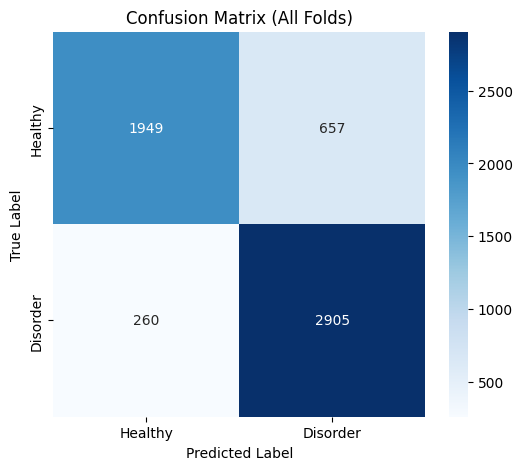

In [ ]:
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

transformer_accuracies = []
all_true = []
all_pred = []
debug_distributions = {}

gkf = GroupKFold(n_splits=10, shuffle=True, random_state=42)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

for fold, (train_idx, val_idx) in enumerate(gkf.split(data_array, label_array, group_array)):
    print(f"\n📂 Fold {fold+1}")
    y_val = label_array[val_idx]
    print("Validation class distribution:", Counter(y_val))


    x_train, y_train = data_array[train_idx], label_array[train_idx]
    x_val, y_val = data_array[val_idx], label_array[val_idx]

    # Feature scaling (standardize across channels)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

    # Build & train transformer model
    model = build_eeg_transformer(input_shape=(1250, 19))
    model.fit(x_train, y_train, epochs=5, batch_size=128,
              validation_data=(x_val, y_val), verbose=0, callbacks=[early_stop])

    # Evaluate accuracy
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    transformer_accuracies.append(val_acc)

    # Predict and store for confusion matrix
    y_val_pred_probs = model.predict(x_val)
    y_val_preds = (y_val_pred_probs > 0.5).astype(int).flatten()
    y_val_true = y_val.flatten()

    all_pred.extend(y_val_preds)
    all_true.extend(y_val_true)

    # Saving Distributions Information
    debug_distributions[fold] = {
        'predicted': dict(Counter(y_val_preds)),
        'true': dict(Counter(y_val_true))
    }

    # Precision & Recall for current fold
    precision = precision_score(y_val_true, y_val_preds, zero_division = 0)
    recall = recall_score(y_val_true, y_val_preds, zero_division=0)

    print(f"✅ Fold {fold+1} Accuracy: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")


# Outside loop
print("\n🧾 Prediction Distributions for All Folds:")
for f, dist in debug_distributions.items():
    print(f"Fold {f+1}: Predicted {dist['predicted']}, True {dist['true']}")

# Final Confusion Matrix
cm = confusion_matrix(all_true, all_pred)
precision_final = precision_score(all_true, all_pred, zero_division=0)
recall_final = recall_score(all_true, all_pred, zero_division=0)

# 🎯 Overall Results
print("\n🎯 Transformer Cross-Validation Metrics:")
print("Each fold accuracy:", transformer_accuracies)
print("Mean Accuracy: {:.4f}".format(np.mean(transformer_accuracies)))
print("Std Dev: {:.4f}".format(np.std(transformer_accuracies)))
print("Overall Precision: {:.4f}".format(precision_final))
print("Overall Recall: {:.4f}".format(recall_final))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Disorder'], yticklabels=['Healthy', 'Disorder'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (All Folds)')
plt.show()


📊 Comparing Performance Metrics Across Different Folds...

Running 5-fold cross-validation...
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step
Finished 5-fold CV. Mean Accuracy: 0.7557 | Precision: 0.8357 | Recall: 0.6848 | F1-Score: 0.7527

Running 10-fold cross-validation...
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step
Finished 10-fold CV. Mean Accuracy: 0.7635 | Precision: 0.7634 | Recall: 0.8494 | F1-Score: 0.8041


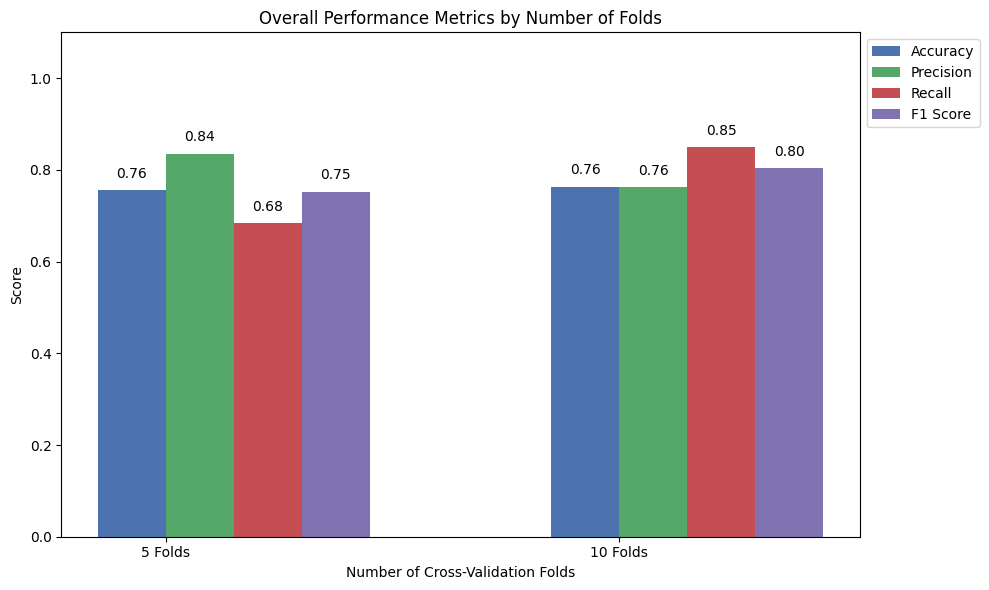


✨ Bar graph for fold comparison is complete!


In [17]:
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

transformer_accuracies = []
all_true = []
all_pred = []
debug_distributions = {}

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# --- New Snippet for N_Splits Comparison ---

print("\n📊 Comparing Performance Metrics Across Different Folds...")
fold_configs = [5, 10]
fold_results = {folds: {'precision': [], 'recall': [], 'f1_score': [], 'accuracy': []} for folds in fold_configs}

for num_folds in fold_configs:
    print(f"\nRunning {num_folds}-fold cross-validation...")
    all_true_folds = []
    all_pred_folds = []
    fold_accuracies = []

    # Initialize a new GroupKFold for each configuration
    gkf_comparison = GroupKFold(n_splits=num_folds)

    for fold, (train_idx, val_idx) in enumerate(gkf_comparison.split(data_array, label_array, group_array)):
        x_train, y_train = data_array[train_idx], label_array[train_idx]
        x_val, y_val = data_array[val_idx], label_array[val_idx]

        # Re-scale data for each new run
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
        x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

        model = build_eeg_transformer(input_shape=(1250, 19))
        model.fit(x_train, y_train, epochs=10, batch_size=128,
                  validation_data=(x_val, y_val), verbose=0, callbacks=[early_stop])

        val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
        fold_accuracies.append(val_acc)

        y_val_pred_probs = model.predict(x_val)
        y_val_preds = (y_val_pred_probs > 0.5).astype(int).flatten()
        y_val_true = y_val.flatten()

        all_pred_folds.extend(y_val_preds)
        all_true_folds.extend(y_val_true)

    # Calculate overall metrics for the current fold setting
    precision_overall = precision_score(all_true_folds, all_pred_folds, zero_division=0)
    recall_overall = recall_score(all_true_folds, all_pred_folds, zero_division=0)
    f1_overall = f1_score(all_true_folds, all_pred_folds, zero_division=0)
    mean_accuracy = np.mean(fold_accuracies)

    fold_results[num_folds]['precision'] = precision_overall
    fold_results[num_folds]['recall'] = recall_overall
    fold_results[num_folds]['f1_score'] = f1_overall
    fold_results[num_folds]['accuracy'] = mean_accuracy

    print(f"Finished {num_folds}-fold CV. Mean Accuracy: {mean_accuracy:.4f} | Precision: {precision_overall:.4f} | Recall: {recall_overall:.4f} | F1-Score: {f1_overall:.4f}")

# Plotting the new bar graph for folds comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']
x_labels = [f'{folds} Folds' for folds in fold_configs]
x = np.arange(len(x_labels))

width = 0.15

for i, metric in enumerate(metrics_to_plot):
    values = [fold_results[folds][metric] for folds in fold_configs]
    ax.bar(x + i * width - 1.5 * width, values, width, label=metric.replace('_', ' ').title(), color=colors[i])

ax.set_ylabel('Score')
ax.set_xlabel('Number of Cross-Validation Folds')
ax.set_title('Overall Performance Metrics by Number of Folds')
ax.set_xticks(x - width)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add value labels on top of the bars
for i, metric in enumerate(metrics_to_plot):
    for j, folds in enumerate(fold_configs):
        val = fold_results[folds][metric]
        ax.text(x[j] + i * width - 1.5 * width, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✨ Bar graph for fold comparison is complete!")